In [4]:
import numpy as np
import os
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as mcolors
import dask.array as da

In [5]:
# reading in ERA5 to compare

base_path = '/data/rong4/Data/ERA5/3hourly/quvw_US'

# Define the range of years and months
years = [str(year) for year in range(1979, 2019)]

def get_files(folder, component):

    files = glob.glob(os.path.join(base_path, folder, f"era5.{component}.*.nc"))

    filtered_files = [f for f in files if any(year in f for year in years)]
    
    return filtered_files

# Get the files for each component
u_files = get_files('u_component_of_wind', 'u_component_of_wind')

v_files = get_files('v_component_of_wind', 'v_component_of_wind')

w_files = get_files('vertical_velocity', 'vertical_velocity')

q_files = get_files('specific_humidity', 'specific_humidity')

all_files = u_files + v_files + q_files + w_files

# open all datasets at once
era5 = xr.open_mfdataset(all_files, combine='by_coords', chunks={'time': 24})

era5sgp = era5.sel(latitude=slice(39.0, 30.0), longitude=slice(-105.0, -95.0))

era5sgp['time'] = era5sgp['time'] - pd.Timedelta(hours=6)

In [6]:
#subsetting for 2011
era2011 = era5sgp.where(era5sgp['time'].dt.year == 2011, drop=True)

night = era2011.sel(time=era2011['time'].dt.hour.isin([0, 6]))

day = era2011.sel(time=era2011['time'].dt.hour.isin([12, 18]))

full = era2011.sel(time=era2011['time'].dt.hour.isin([0, 6, 12, 18]))

night = night.resample(time='ME').mean()

day = day.resample(time='ME').mean()

full = full.resample(time='ME').mean()

In [7]:
#subsetting for climatology

clim = era5sgp.sel(time=slice('1979-01-01', '2018-12-31'))

cnight = clim.sel(time=clim['time'].dt.hour.isin([0, 6]))

cday = clim.sel(time=clim['time'].dt.hour.isin([12, 18]))

cfull = clim.sel(time=clim['time'].dt.hour.isin([0, 6, 12, 18]))

cnight = cnight.groupby('time.month').mean('time')

cday = cday.groupby('time.month').mean('time')

cfull = cfull.groupby('time.month').mean('time')

In [8]:
all_times = {
    
    'clim full': cfull,
    
    '2011 night': night,
    
    '2011 day': day,
        
    'clim night': cnight,
    
    'clim day': cday 
    
}

In [9]:
def calculate_horizontal_advection(u, v, q, lat, lon):

    R = 6371000  # radius of Earth (meters)
    
    rho_water = 1000 # kg/m^3
    
    seconds_to_day = 60 * 60 * 24 # to convert from s --> day

    latitude_range = np.sin(np.radians(lat[-1])) - np.sin(np.radians(lat[0]))
    
    longitude_range = np.radians(lon[-1]) - np.radians(lon[0])
    
    lon_grid, lat_grid = np.meshgrid(np.radians(lon), np.radians(lat))
    
    delta_y = np.radians(lat[1]) - np.radians(lat[0])
    delta_x = np.radians(lon[1]) - np.radians(lon[0])
    
    # shaped as (#lons, #lats) so first row represents all values for first latitude (eg: 30,30,30...)
    cos_correction = np.cos(lat_grid)
    
    dqdx = np.zeros_like(q)
    dqdy = np.zeros_like(q)
    
    # Loop through each pressure level
    for k in range(u.shape[0]):
        
        # Central points
    
        dqdx[k, :, 1:-1] = (q[k, :, 2:] - q[k, :, :-2]) / (2 * delta_x)
        dqdy[k, 1:-1, :] = (q[k, 2:, :] - q[k, :-2, :]) / (2 * delta_y)
        
        # Left and right boundaries (x-direction)
        
        dqdx[k, :, 0] = (q[k, :, 1] - q[k, :, 0]) / (delta_x)
        dqdx[k, :, -1] = (q[k, :, -2] - q[k, :, -1]) / (delta_x)

        # Top and bottom boundaries (y-direction)
        
        dqdy[k, 0, :] = (q[k, 1, :] - q[k, 0, :]) / (delta_y)
        dqdy[k, -1, :] = (q[k, -2, :] - q[k, -1, :]) / (delta_y)
        
        dx = R * cos_correction * delta_x
        dy = R * delta_y

        # for every grid point, multiply by the area extent of that grid box 
        
        dqdy[k] = (1/R) * dqdy[k] * dx * dy
        
        dqdx[k] = (1/(R*cos_correction)) * dqdx[k] * dx * dy
        
    meridional_advection = -(v * dqdy)
    
    zonal_advection = -(u * dqdx)
    
    total_area = []
    
    for i in dx: 
        
        total_area.append(i*dy)
        
    A = np.sum(total_area)
    
    # Area weighted average
    zonal_advection_area_weighted = np.sum(zonal_advection, axis=(1,2))*(1/A)*seconds_to_day*rho_water
    
    meridional_advection_area_weighted = np.sum(meridional_advection, axis=(1,2))*(1/A)*seconds_to_day*rho_water

    # Units = 10^3/day 
    # Shapes returned: (#pressure levels) because advection is averaged over the domain for every level 
    
    return zonal_advection_area_weighted, meridional_advection_area_weighted

In [60]:
def calculate_vertical_advection(w, q, pressure, lat, lon):
    """
    Calculate vertical advection of specific humidity over a domain without flipping the pressure array.
    
    Args:
        w (ndarray): Vertical velocity (Pa/s), shape = (levels, lat, lon).
        q (ndarray): Specific humidity (kg/kg), shape = (levels, lat, lon).
        pressure (ndarray): Pressure levels (Pa), shape = (levels,).
        lat (ndarray): Latitude values (degrees), shape = (lat,).
        lon (ndarray): Longitude values (degrees), shape = (lon,).
    
    Returns:
        vertical_advection_area_weighted (ndarray): Area-weighted vertical advection (mm/day),
                                                    shape = (levels,).
    """
    R = 6371000  # radius of Earth (meters)
    
    rho_water = 1000  # kg/m^3
    
    seconds_to_day = 60 * 60 * 24  # to convert from s --> day

    # Grid spacing and corrections
    
    delta_y = np.radians(lat[1]) - np.radians(lat[0])
    
    delta_x = np.radians(lon[1]) - np.radians(lon[0])
    
    lon_grid, lat_grid = np.meshgrid(np.radians(lon), np.radians(lat))
    
    cos_correction = np.cos(lat_grid)

    dx = R * cos_correction * delta_x  # Zonal grid spacing in meters
    
    dy = R * delta_y                   # Meridional grid spacing in meters
    
    grid_area = dx * dy                # Area of each grid cell (lat, lon)
        
    total_area = np.sum(grid_area)     # Total domain area
    
    # Initialize the vertical gradient array
    dqdp = np.zeros_like(q)

    # Compute vertical gradient of specific humidity (dq/dp)
    for j in range(1, q.shape[0] - 1):  # Central differencing for interior levels
        
        dqdp[j, :, :] = (q[j - 1, :, :] - q[j + 1, :, :]) / (pressure[j - 1] - pressure[j + 1])

    # Forward/backward differencing for boundaries
    dqdp[0, :, :] = (q[0, :, :] - q[1, :, :]) / (pressure[0] - pressure[1])
    
    dqdp[-1, :, :] = (q[-2, :, :] - q[-1, :, :]) / (pressure[-2] - pressure[-1])

    # Vertical advection term: -omega * dq/dp
    vertical_advection = -(w * dqdp)  # Shape = (levels, lat, lon)
    
    # Area-weighted average across the domain for each pressure level
    vertical_advection_area_weighted = np.sum(vertical_advection * grid_area, axis=(1, 2)) / total_area

    # Convert to mm/day
    vertical_advection_area_weighted *= seconds_to_day * rho_water  

    return vertical_advection * seconds_to_day * rho_water

In [11]:
u = full['u'].load().data[:, :, ::-1, :]
print("u loaded")

v = full['v'].load().data[:, :, ::-1, :]
print("v loaded")

q = full['q'].load().data[:, :, ::-1, :] 
print("q loaded")

w = full['w'].load().data[:, :, ::-1, :] 
print("w loaded")

pressure = full['level'].data * 100 

latitude = full['latitude'].data[::-1]

longitude = full['longitude'].data

u loaded
v loaded
q loaded
w loaded


In [91]:
## inspection 

test = calculate_vertical_advection(w[7], q[7], pressure, latitude, longitude)

np.max(test), np.min(test)

(7.085477257061136, -4.586658274623375)

In [49]:
# to append

zonal_advection_profile = []

meridional_advection_profile = []

vertical_advection_profile = []

# Looping over every month
months = u.shape[0]

for i in range(months):

    # horizontal advection
    zonal_adv, merid_adv = calculate_horizontal_advection(u[i], v[i], q[i], latitude, longitude)
    
    # append horizontal advection
    zonal_advection_profile.append(zonal_adv)
    
    meridional_advection_profile.append(merid_adv)
    
    # vertical advection
    vertical_adv = calculate_vertical_advection(w[i], q[i], pressure, latitude, longitude)
    
    # append vertical advection 
    vertical_advection_profile.append(vertical_adv)
    
zonal_advection_profile = np.array(zonal_advection_profile)

meridional_advection_profile = np.array(meridional_advection_profile)

vertical_advection_profile = np.array(vertical_advection_profile)

## plotting advection Hovmoller diagrams below

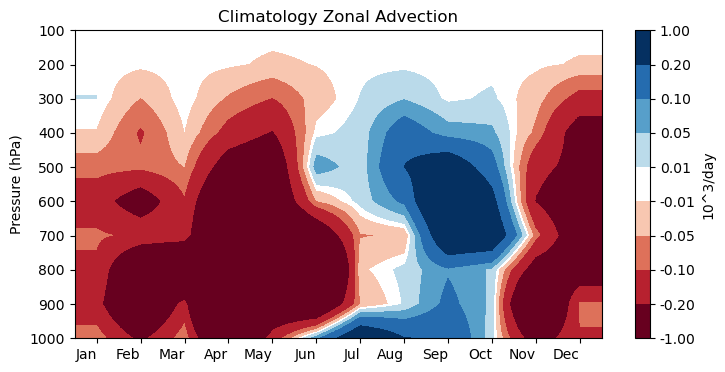

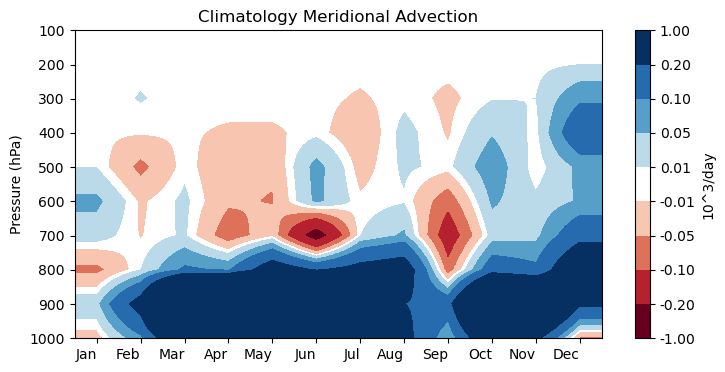

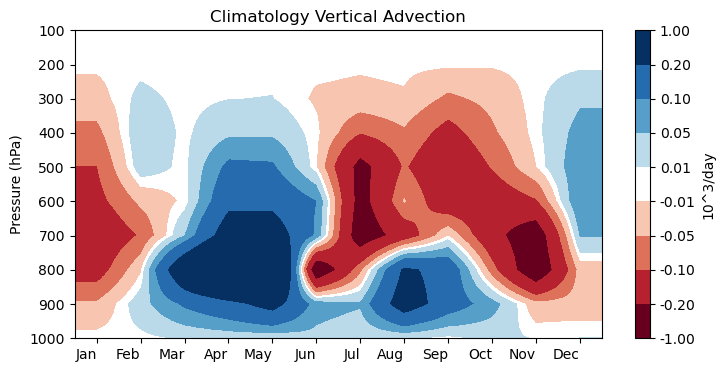

In [24]:
profs_to_plot = [zonal_advection_profile, meridional_advection_profile, vertical_advection_profile]

titles = ['Zonal', 'Meridional', 'Vertical']

pressure_levels = full['level'].data

levels = np.array([-1, -0.2, -0.1, -0.05, -0.01, 0.01, 0.05, 0.1, 0.2, 1])

colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', 'white', 'white', '#92c5de', '#4393c3', '#2166ac', '#053061']

cmap = mcolors.LinearSegmentedColormap.from_list("custom_coolwarm", colors, N=len(levels) - 1)

norm = mcolors.BoundaryNorm(levels, ncolors=len(levels) - 1, clip=True)

# Subset pressure levels and data to go up to 100 hPa
pressure_subset = pressure_levels[(pressure_levels >= 100) & (pressure_levels % 100 == 0)]

pressure_indices = np.isin(pressure_levels, pressure_subset).nonzero()[0]  # Indices for data subsetting

for i, arr in enumerate(profs_to_plot):
    
    plt.figure(figsize=(8.5, 4))
    
    # Subset data to match the pressure range up to 100 hPa
    hovmoller_data = np.array(arr)[:, pressure_indices]

    # Plot data without forcing extent to allow automatic scaling
    plt.imshow(hovmoller_data.T, aspect='auto', origin='lower', cmap=cmap, norm=norm, interpolation='bilinear')
    
    # Set x-axis labels
    plt.xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
               ha='right')

    plt.ylim(0, len(pressure_subset) - 1)  # Reverse to show top level first
    
    plt.yticks(np.arange(len(pressure_subset)), pressure_subset)

    plt.ylabel('Pressure (hPa)')

    # Color bar with custom tick labels
    cbar = plt.colorbar(label='10^3/day', ticks=levels)
    cbar.ax.set_yticklabels(['<-0.2', '-0.2', '-0.1', '-0.05', '-0.01', '0.01', '0.05', '0.1', '0.2', '>0.2'])

    cbar.ax.set_yticklabels([f"{level:.2f}" for level in levels])

    # Set title and show plot
    plt.title('Climatology {} Advection'.format(titles[i]))
    plt.gca().invert_yaxis()
    plt.show()

In [25]:
def vertically_integrated_advection(u, v, w, q, levels, lat, lon):
    
    g = 9.81  # Gravitational acceleration in m/s^2
    
    rho_water = 1000  # Density of water in kg/m^3

    # Get the moisture budget profiles
    zonal_advection_area_weighted, meridional_advection_area_weighted = calculate_horizontal_advection(u, v, q, lat, lon)
    
    vertical_advection_area_weighted = calculate_vertical_advection(w, q, levels, lat, lon)
    
    # Calculate dp, with the sign depending on your dataset's vertical structure
    dp = np.diff(levels)

    # Create a dictionary to store the input profiles and the integrated results
    profiles = {
        "zonal_advection_integrated": zonal_advection_area_weighted,
        "meridional_advection_integrated": meridional_advection_area_weighted,
        "vertical_advection_integrated": vertical_advection_area_weighted
    }
    
    
    integrated_results = {}  # Dictionary to store integrated results

    for name, profile in profiles.items():
        
        integrated_results[name] = np.sum(0.5 * (profile[:-1] + profile[1:]) * dp) / (g * rho_water)

    return integrated_results

In [26]:
integrated_results = {}  # Main dictionary to store results for all datasets

for df_name, df in all_times.items():
    print(df_name)
    
    identifier = df_name
    
    u = df['u'].load().data[:, :, ::-1, :] 
    print("u loaded")
    
    v = df['v'].load().data[:, :, ::-1, :]
    print("v loaded")
    
    w = df['w'].load().data[:, :, ::-1, :]
    
    q = df['q'].load().data[:, :, ::-1, :] 
    print("q loaded")
    
    levels = df['level'].data * 100 
    
    lat = df['latitude'].data[::-1]
    
    lon = df['longitude'].data
    
    months = u.shape[0]
    
    integrated_results[df_name] = {
        "zonal adv": [],
        "merid adv": [],
        "vertical adv": []
    }
    
    # Loop over every month 
    for i in range(months):

        advection_results = vertically_integrated_advection(u[i], v[i], w[i], q[i], levels, lat, lon)
        
        # Append the results to the corresponding lists
        integrated_results[df_name]["zonal adv"].append(advection_results["zonal_advection_integrated"])
        
        integrated_results[df_name]["merid adv"].append(advection_results["meridional_advection_integrated"])
        
        integrated_results[df_name]["vertical adv"].append(advection_results["vertical_advection_integrated"])


clim full
u loaded
v loaded
q loaded
2011 night
u loaded
v loaded
q loaded
2011 day
u loaded
v loaded
q loaded
clim night
u loaded
v loaded
q loaded
clim day
u loaded
v loaded
q loaded


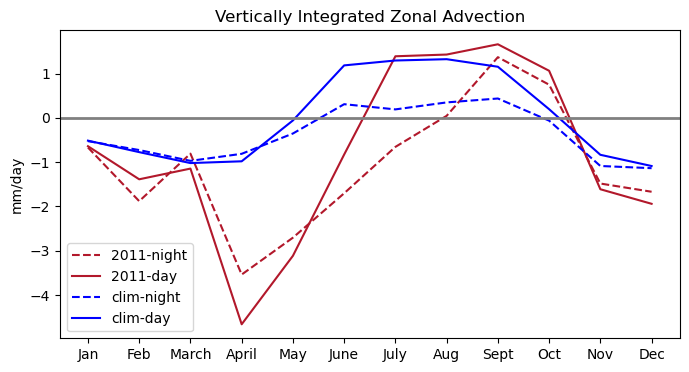

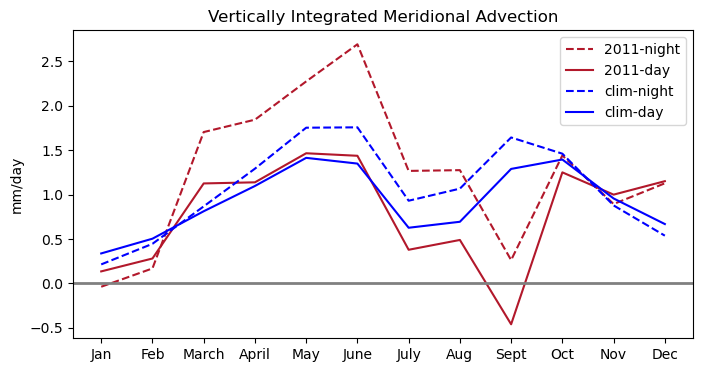

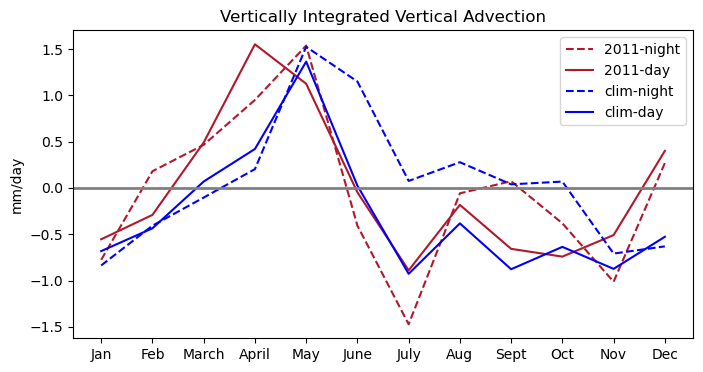

In [27]:
# zonal

fig, ax = plt.subplots(figsize=(8, 4))

months=["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

plt.plot(months, integrated_results['2011 night']['zonal adv'], color='#b2182b', linestyle='--', label='2011-night')

plt.plot(months, integrated_results['2011 day']['zonal adv'], color='#b2182b', label='2011-day')

plt.plot(months, integrated_results['clim night']['zonal adv'], color='blue', linestyle='--', label='clim-night')

plt.plot(months, integrated_results['clim day']['zonal adv'], color='blue', label='clim-day')

plt.axhline(0, color='grey', linewidth=2)

plt.ylabel("mm/day")

plt.title("Vertically Integrated Zonal Advection")

# plt.ylim(-5,2)

plt.legend()

plt.show()


# meridional 

fig, ax = plt.subplots(figsize=(8, 4))

months=["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

plt.plot(months, integrated_results['2011 night']['merid adv'], color='#b2182b', linestyle='--', label='2011-night')

plt.plot(months, integrated_results['2011 day']['merid adv'], color='#b2182b', label='2011-day')

plt.plot(months, integrated_results['clim night']['merid adv'], color='blue', linestyle='--', label='clim-night')

plt.plot(months, integrated_results['clim day']['merid adv'], color='blue', label='clim-day')

plt.axhline(0, color='grey', linewidth=2)

plt.title("Vertically Integrated Meridional Advection")

plt.ylabel("mm/day")

# plt.ylim(-5,2)

plt.legend()

plt.show()

# vertical

fig, ax = plt.subplots(figsize=(8, 4))

months=["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

plt.plot(months, integrated_results['2011 night']['vertical adv'], color='#b2182b', linestyle='--', label='2011-night')

plt.plot(months, integrated_results['2011 day']['vertical adv'], color='#b2182b', label='2011-day')

plt.plot(months, integrated_results['clim night']['vertical adv'], color='blue', linestyle='--', label='clim-night')

plt.plot(months, integrated_results['clim day']['vertical adv'], color='blue', label='clim-day')

plt.axhline(0, color='grey', linewidth=2)

plt.title("Vertically Integrated Vertical Advection")

plt.ylabel("mm/day")

# plt.ylim(-5,2)

plt.legend()

plt.show()